In [11]:
import tensorflow as tf 
import numpy as np

import json

from sklearn.model_selection import train_test_split

import feature as fe 
import copy 
from tensorflow.keras import *

import seaborn as sns 
import matplotlib
import matplotlib.pyplot as plt 
import pandas as pd 
import kerastuner as kt
import datetime
import os 

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

matplotlib.rcParams['font.family']='Heiti TC'#修改了全局变量

%matplotlib inline 
%config InlineBackend.figure_format = 'jpg' #以矢量图的形式显示图片，这样比较清晰
plt.style.use({'figure.figsize':(20,16)})



def getTimeNow():
    now = datetime.datetime.now()
    return datetime.datetime.strftime(now,'%Y%m%d%H%M%S')



def drawlossinTwoSet(data,modelname='未知'):
    y1 = data.history['loss']
    y2 = data.history['val_loss']
    x = range(len(y1))
    #modelname= 'TotalFeaturesmodel'
    filename = modelname+'loss'

    sns.lineplot(x =x  ,y=y1)
    plt.xticks(ticks=x,labels=['epoch'+ str(i+1)for i in x],fontsize=1)
    #for i,j in zip(x,y1):
        #plt.text(i,j+0.005*j,'loss={:.2}'.format(j),fontsize=12)
    #plt.hlines(max(y1),x[-20],x[-1])
    plt.text(x[-9],max(y1),'train_loss= {:.5}'.format(max(y1)),fontsize=14)

    sns.lineplot(x=x,y=y2,color='b')

    plt.text(x[-9],np.median(y2),'val_loss= {:.5}'.format(np.median(y2)),fontsize=14)

    #for i,j in zip(x,y2):
        #plt.text(i,j-0.01*j,'loss={:.2}'.format(j),color = 'b',fontsize=12)
    plt.title('牛奶过敏BCEs'+modelname+'模型训练loss结果图',fontsize=30)    

    plt.legend(['训练集','测试集'],loc='upper left',fontsize=30)
    #plt.savefig(filename+'.jpg',dpi=500)

def drawACCinTwoSet(data,modelname='未知'):
    y1 = data.history['acc']
    y2 = data.history['val_acc']
    x = range(len(y1))
    #modelname= 'TotalFeaturesmodel'
    filename = modelname+'ACC'

    sns.lineplot(x =x  ,y=y1)
    plt.xticks(ticks=x,labels=['epoch'+ str(i+1)for i in x],fontsize=1)
    #for i,j in zip(x,y1):
        #plt.text(i,j+0.005*j,'acc={:.2}'.format(j),fontsize=12)
    #plt.hlines(max(y1),x[-20],x[-1])
    plt.text(x[-9],max(y1),'train_acc= {:.5}'.format(max(y1)),fontsize=14)

    sns.lineplot(x=x,y=y2,color='b')

    plt.text(x[-9],np.median(y2),'val_acc= {:.5}'.format(np.median(y2)),fontsize=14)

    #for i,j in zip(x,y2):
        #plt.text(i,j-0.01*j,'acc={:.2}'.format(j),color = 'b',fontsize=12)
    plt.title('牛奶过敏BCEs'+modelname+'模型训练acc结果图',fontsize=30)    

    plt.legend(['训练集','测试集'],loc='upper left',fontsize=30)
    #plt.savefig(filename+'.jpg',dpi=500)
def countFeatures(data):
    import feature 
    """
    input: 输入BCEs或者非BCEs的数据集 pd.DataFrame类型
    output:输出包含AAC、DPC、CTD和AAI的 pd.DataFrame类型
    
    """
    #计算AAC
    data['AAC']= data['Description'].apply(fe.CalculateAAComposition)
    #计算DPC
    data['DPC']= data['Description'].apply(fe.CalculateDipeptideComposition)
    #计算CTD
    data['CTD']= data['Description'].apply(fe.CalculateCTD)
    #计算AAI
    data['AAI']= data['Description'].apply(fe.CalculateAAIndex)
    return data

def applynumpyArray1D(arr,func):
    """
    
    """
    array = copy.deepcopy(arr)  
    for i in range(array.shape[0]):
        array[i] = func(array[i])
    return array

def normize(array):
    """
    input: np.array shape = (n,) 一维向量 
    output: 对 输入的数据进行归一化，即 (a_i - a.mean())/a.std  若全为0，则返回原array。
    
    """
    temp = copy.deepcopy(array)
    if (array == 0).all():#应当添加()
        normizedarray = temp
    else:
        normizedarray = (temp-temp.mean())/temp.std()
    return normizedarray
def twoDArraynormize(twoDArray):
    """
    input: np.array, shape = (n,m)  n为样本个数，m为特征个数，  对每一个样本的同一个特征进行归一化处理即 (m_i - m's mean)/m'std
    output: np.array, shape = (n,m) n为样本个数，m为特征个数。 归一化后的结果 

    """
    temp = copy.deepcopy(twoDArray)
    for i in range(temp.shape[1]):
        array = temp[:,i]
        temp[:,i] = normize(array)
    return temp    
    

#词向量化
def amino_acids2numvector(sequenceArray,toknizer):
    """
    input:
        sequence:(n,) np.array类型，多肽序列
        toknizer: 氨基酸toknizer。    
    output:（n,200) 数字化后的多肽序列
    """
    sequenceArray = applynumpyArray1D(sequenceArray,lambda x: ' '.join(x))
    sequenceArray = toknizer.texts_to_sequences(sequenceArray)
    #选取最常长度为20
    sequenceArray = tf.keras.preprocessing.sequence.pad_sequences(sequenceArray,truncating='post',padding='post',maxlen=20)
    return sequenceArray


#AAC Matrix
def aminoacids2AACMatrix(array):
    """
    
    """
    tmp = copy.deepcopy(array)
    tmp = applynumpyArray1D(tmp,fe.CalculateAAComposition)
    AACMatrix = applynumpyArray1D(tmp,lambda x: [i for i in x.values()])#输出是（n,)的shape
    #转化为np.array，shape为（n,20）
    AACMatrix = np.array(AACMatrix.tolist())
    return AACMatrix

#DPC Matrix
#DPC Matrix
def aminoacids2DPCMatrix(array):
    """
    
    """
    tmp = copy.deepcopy(array)
    tmp = applynumpyArray1D(tmp,fe.CalculateDipeptideComposition)
    DPCMatrix = applynumpyArray1D(tmp,lambda x: [i for i in x.values()])#输出是（n,)的shape
    #转化为np.array，shape为（n,20）
    DPCMatrix = np.array(DPCMatrix.tolist())
    return DPCMatrix

#CTD Matrix
def aminoacids2CTDMatrix(array):
    """
    
    """
    tmp = copy.deepcopy(array)
    tmp = applynumpyArray1D(tmp,fe.CalculateCTD)
    CTDMatrix = applynumpyArray1D(tmp,lambda x: [i for i in x.values()])#输出是（n,)的shape
    #转化为np.array，shape为（n,20）
    CTDMatrix = np.array(CTDMatrix.tolist())
    return CTDMatrix
#AAI Matrix
def aminoacids2AAIMatrix(array):
    """
    
    """
    tmp = copy.deepcopy(array)
    tmp = applynumpyArray1D(tmp,fe.CalculateAAIndex)
    AAIMatrix = applynumpyArray1D(tmp,lambda x: [i for i in x.values()])#输出是（n,)的shape
    #转化为np.array，shape为（n,20）
    AAIMatrix = np.array(AAIMatrix.tolist())
    return AAIMatrix


def generateFeaturesData(sequenceData,normize=False):
    """
    input:
        sequence:(n,) np.array类型，包含n条多肽序列的数组
    output:[AAC,DPC,CTD,AAI,SeqVec]的一个列表
    """
    data = copy.deepcopy(sequenceData)
    AAC = aminoacids2AACMatrix(data)
    if normize:
        AAC = twoDArraynormize(AAC)
    
    DPC = aminoacids2DPCMatrix(data)
    if normize:
        DPC = twoDArraynormize(DPC)
    
    CTD = aminoacids2CTDMatrix(data)
    if normize:
        CTD = twoDArraynormize(CTD)
    
    AAI = aminoacids2AAIMatrix(data)
    #if normize:
    AAI = twoDArraynormize(AAI)
    
    SeqVec = amino_acids2numvector(data,toknizer)
    return [AAC,DPC,CTD,AAI,SeqVec]


# def PCA(X,k):
#     """
#     input：
#         X：原数据，np.array类型，shape=(n,m),n为样本数目，m为维度
#         k：降低到多少维
#     output:
#         Y：降维后的数据，shape=(n,k)
#     """
#     number = X.shape[0]
#     dimension = X.shape[1]
#     X = X - X.mean(axis=0)
#     C = np.dot(X.T,X)/number
    
#     eig_val,eig_vec = np.linalg.eig(C)
    
#     eig_List = [(np.abs(eig_val[i]),eig_vec[:,i]) for i in range(dimension)]
#     try:
#         eig_List.sort(reverse=True)
#         P = np.array([each_List[1] for each_List in eig_List[:k]])
#         Y = np.dot(X,P.T)
#         return Y 
#     except:
#         print('出现特征值相同的情况啦，该代码无法继续运行下去，换用其他方式进行PCA处理！')
#         return eig_List
    


In [3]:
#读取 词分类器
with open('tfsModel/RNNamino_acids_toknizer.json','r') as f:
    toknizer =tf.keras.preprocessing.text.tokenizer_from_json(json.load(f))

In [17]:
#IBCE-EL的数据集
B_positive = pd.read_csv('IBCE_EL_B_positive.csv')['0'].values
B_negative = pd.read_csv('IBCE_EL_B_negative.csv')['0'].values
B_positiveFeatures = generateFeaturesData(B_positive)
B_negativeFeatures = generateFeaturesData(B_negative)

IBCE_ELTargets = np.concatenate([np.ones((B_positive.shape[0],)),np.zeros((B_negative.shape[0],))])
B_positive.shape,B_negative.shape ,IBCE_ELTargets.shape 


((4440,), (5485,), (9925,))

In [19]:
np.concatenate([B_positiveFeatures[0],B_negativeFeatures[0]])

array([[0.   , 0.067, 0.   , ..., 0.   , 0.133, 0.   ],
       [0.   , 0.   , 0.067, ..., 0.   , 0.   , 0.067],
       [0.133, 0.   , 0.067, ..., 0.   , 0.067, 0.067],
       ...,
       [0.067, 0.   , 0.   , ..., 0.   , 0.   , 0.133],
       [0.2  , 0.   , 0.067, ..., 0.   , 0.   , 0.   ],
       [0.067, 0.   , 0.   , ..., 0.   , 0.067, 0.067]])

## 对IBCE-EL数据集进行PCA分析

In [43]:
#PCA分析
i= 4 
X = np.concatenate([B_positiveFeatures[i],B_negativeFeatures[i]])
X_r = PCA(n_components=2).fit(X).transform(X)
x1 = X_r[:, 0]
x2 = X_r[:, 1]
#绘图
plt.scatter(x1[:4440], x2[:4440], c='b')
#plt.scatter(x1[4440:9925], x2[4440:9925], c='g')
plt.legend(['BCE','非BCE'],loc='upper left',fontsize=30)
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.show()

IndexError: index 1 is out of bounds for axis 1 with size 1

ValueError: n_components cannot be larger than min(n_features, n_classes - 1).

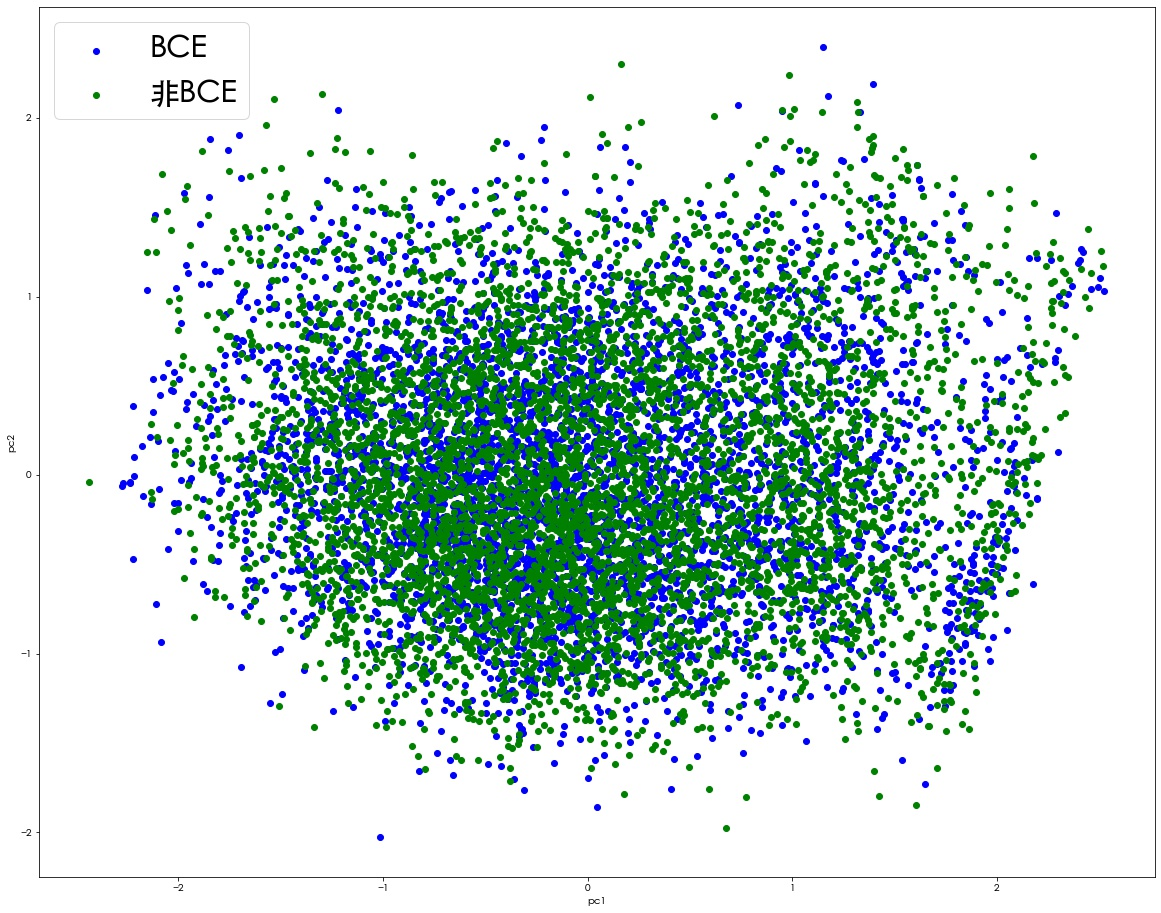

In [29]:
X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')


In [32]:
milkAllergyBCEs = pd.read_csv('milk allergy linear BCEs bovine dataset.csv')['Description'].values
milkAllergynonBCEs = pd.read_csv('milk allergy linear non-BCEs experiece confirmed.csv')['Description'].values
milkAllergyBCEsFeatures = generateFeaturesData(milkAllergyBCEs)
milkAllergynonBCEsFeatures = generateFeaturesData(milkAllergynonBCEs)
milkAllergyTargets = np.concatenate([np.ones((milkAllergyBCEsFeatures[0].shape[0],)),np.zeros((milkAllergynonBCEsFeatures[0].shape[0],))])

In [34]:
milkAllergyBCEs.shape,milkAllergynonBCEs.shape,milkAllergyTargets.shape 

((238,), (226,), (464,))

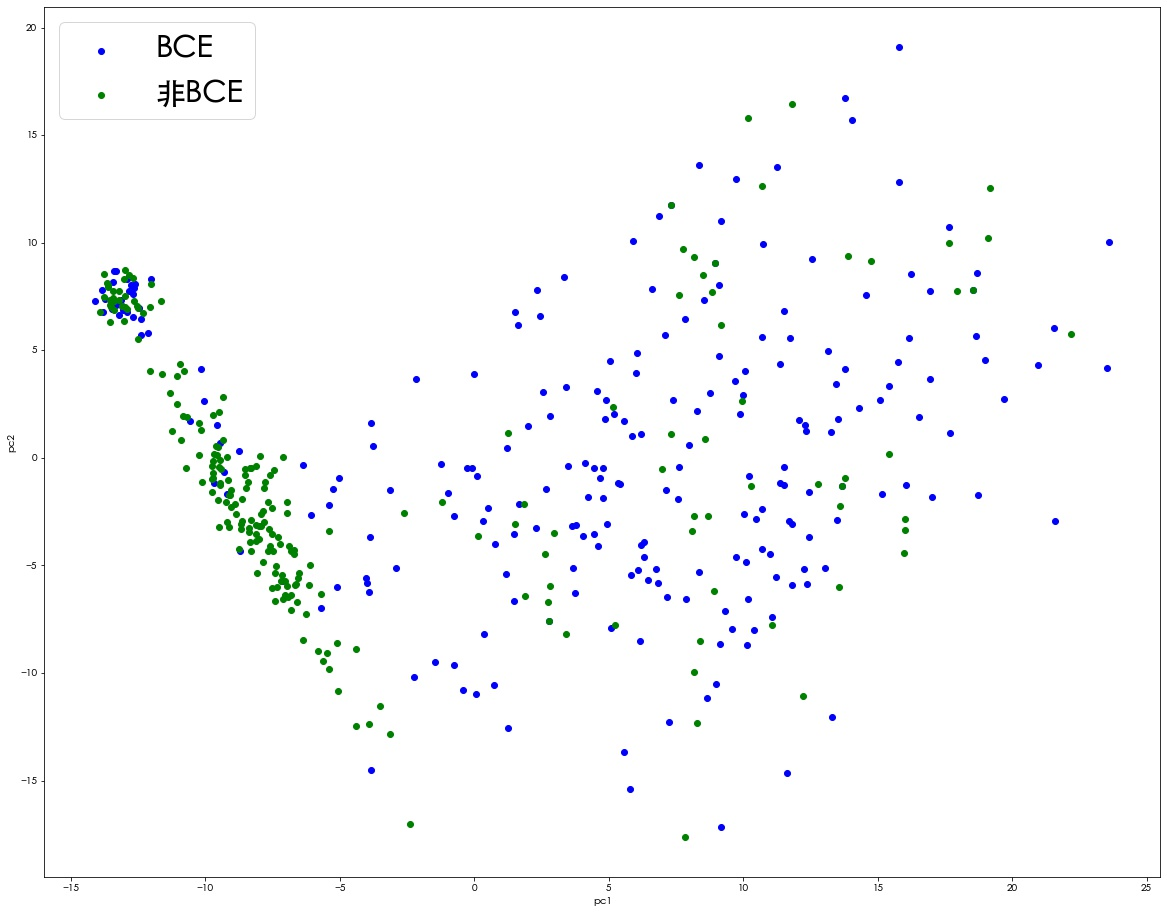

In [38]:

#PCA分析
i= 4 
X = np.concatenate([milkAllergyBCEsFeatures[i],milkAllergynonBCEsFeatures[i]])
X_r = PCA(n_components=2).fit(X).transform(X)
x1 = X_r[:, 0]
x2 = X_r[:, 1]
#绘图
plt.scatter(x1[:238], x2[:238], c='b')
plt.scatter(x1[238:464], x2[238:464], c='g')
plt.legend(['BCE','非BCE'],loc='upper left',fontsize=30)
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.show()